In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DRQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DRQN, self).__init__()
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.hidden_size = 128
        
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.lstm = nn.LSTM(128, 128)
        self.fc = nn.Linear(128, n_actions)

    def forward(self, x, hidden=None):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.unsqueeze(0)  # Add a time dimension
        if hidden is not None:
            x, hidden = self.lstm(x, hidden)
        else:
            x, hidden = self.lstm(x)
        x = x.squeeze(0)  # Remove the time dimension
        x = self.fc(x)
        return x
    

class DRQNsmall(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DRQNsmall, self).__init__()
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.hidden_size = 64
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.lstm = nn.LSTM(64, 64)
        self.fc = nn.Linear(64, n_actions)

    def forward(self, x, hidden=None):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.unsqueeze(0)  # Add a time dimension
        if hidden is not None:
            x, hidden = self.lstm(x, hidden)
        else:
            x, hidden = self.lstm(x)
        x = x.squeeze(0)  # Remove the time dimension
        x = self.fc(x)
        return x

def basicLoss(teacher, student, data, target):
    criterion = nn.SmoothL1Loss()
    loss = criterion(student(data), teacher(data))
    return loss

def tempuratureLoss(teacher, student, data, target):
    temperature = 4.0
    soft_targets_weight = temperature * temperature
    label_loss_weight = 0
    criterion = nn.SmoothL1Loss()
    kl_div_loss = nn.KLDivLoss(log_target=True)
    
    large_logits = teacher(data)
    output = student(data)
    soft_targets = nn.functional.log_softmax(large_logits / temperature, dim=-1)
    soft_prob = nn.functional.log_softmax(output / temperature, dim=-1)
    
    soft_targets_loss = kl_div_loss(soft_prob, soft_targets)
    label_loss = criterion(output, large_logits)
    loss = soft_targets_weight * soft_targets_loss + label_loss_weight * label_loss
    return loss

In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
class DRL():

    def __init__(self, net, distil = False, distilNet = None, lossF = None):
        self.memory = ReplayMemory(10000)
        self.policy_net = net.to(device)
        self.target_net = copy.deepcopy(self.policy_net).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.steps_done = 0
        self.distil = distil
        self.distilNet = distilNet
        self.lossF = lossF

    def select_action(self, state):
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        criterion = nn.SmoothL1Loss()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
            
        if self.distil:
            
            loss = self.lossF(self.distilNet, self.policy_net, state_batch, expected_state_action_values.unsqueeze(1))
            
        else:
            
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def step(self, state, info):
        for t in count():
            action = self.select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            self.memory.push(state, action, next_state, reward)

            state = next_state

            self.optimize_model()

            self.target_net_state_dict = self.target_net.state_dict()
            self.policy_net_state_dict = self.policy_net.state_dict()
            for key in self.policy_net_state_dict:
                self.target_net_state_dict[key] = self.policy_net_state_dict[key]*TAU + self.target_net_state_dict[key]*(1-TAU)
            self.target_net.load_state_dict(self.target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break
    def outputNet(self):
        return self.policy_net.state_dict()

In [7]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

Complete
Discrete(2)


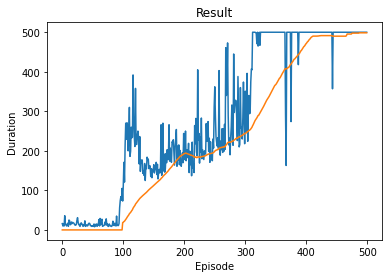

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
teacher = DRL(DRQN(n_observations, n_actions))
episode_durations = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    teacher.step(state, info)
    
print('Complete')
print(env.action_space)
plot_durations(show_result=True)
plt.ioff()
plt.show()

Complete


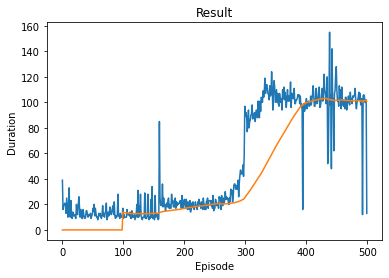

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
compare = DRL(DRQNsmall(n_observations, n_actions))

episode_durations = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    compare.step(state, info)
    
print('Complete')

plot_durations(show_result=True)
plt.ioff()
plt.show()

Complete


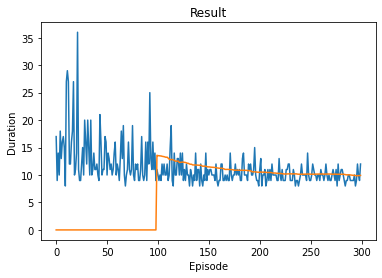

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
teacherNet = DRQN(n_observations, n_actions)
teacherNet.load_state_dict(teacher.outputNet())
student = DRL(DRQNsmall(n_observations, n_actions), True, teacherNet, basicLoss)

episode_durations = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    student.step(state, info)
    
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [11]:
teacherNet = DRQN(n_observations, n_actions)
teacherNet.load_state_dict(teacher.outputNet())
student = DRL(DRQNsmall(n_observations, n_actions), True, teacherNet, tempuratureLoss)

episode_durations = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    student.step(state, info)
    
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [113]:
plt.savefig('teacher.png')

In [66]:
plt.show()

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create the teacher network
teacher_net = DRQN(n_observations, n_actions)

# Create the student network
student_net = DRQNsmall(n_observations, n_actions)

# Count parameters in the teacher network
teacher_params = count_parameters(teacher_net)
print(f"Number of parameters in teacher network: {teacher_params}")

# Count parameters in the student network
student_params = count_parameters(student_net)
print(f"Number of parameters in student network: {student_params}")

Number of parameters in teacher network: 149506
Number of parameters in student network: 37890
